Deep Learning Project: Bank Marketing Campaign Prediction

Introduction

Problem Description:
The goal of this project is to predict whether a client will subscribe to a term deposit (target variable: `deposit`) based on their demographic and financial information. This is a binary classification problem where we aim to build a deep learning model to predict the outcome of a bank marketing campaign.

Dataset Description: The dataset contains information about clients, such as age, job, marital status, education, and financial details like balance and loan status. The target variable is `deposit`, which indicates whether the client subscribed to a term deposit (`yes` or `no`).


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import plotly.express as px
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

Exploratory Data Analysis(EDA)

First, I load the dataset and perform an initial exploration to understand its structure and contents.

Dataset Columns:

Personal Information: Customer's age, Type of job, Marital status and Education level.
Financial Information: Credit in default, Account balance, Housing loan status and Personal loan status.
Last Contact of the Current Campaign: Communication type, Last contact day, Last contact month and Duration of last contact.
Other Attributes: Number of contacts in the campaign, Days since last contact in a previous campaign, Number of previous contacts and Outcome of the previous campaign.
Output Variable (Target): Subscription to a term deposit.


In [2]:
# Load the dataset
data_path = '/kaggle/input/bank-marketing-dataset/bank.csv'
df = pd.read_csv(data_path)

# Display dataset info
print("Dataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None

Missing Values:
age          0
job          0
marital      0
education  

I preprocess the data by handling missing values, encoding categorical variables, and scaling numerical features.

In [3]:
# Create a copy of the dataset
df_clean = df.copy()

# Get numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

# Replace infinite values with NaN
df_clean[numeric_cols] = df_clean[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Drop rows with missing values
df_clean = df_clean.dropna()

# Encode categorical variables
df_cleaned = pd.get_dummies(df_clean, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df_scaled = df_cleaned.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("Data preprocessing completed successfully")

Data preprocessing completed successfully


I create visualizations to understand the distribution of features, detect outliers, and analyze correlations.

<Figure size 1200x1000 with 0 Axes>

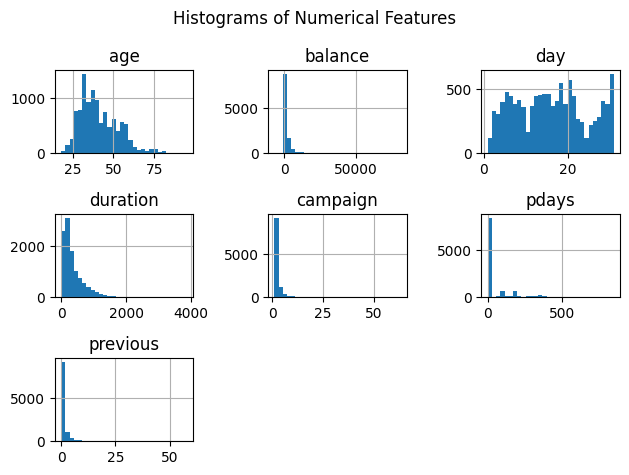

In [4]:
plt.figure(figsize=(12, 10))
df_cleaned[numeric_cols].hist(bins=30)
plt.suptitle("Histograms of Numerical Features")
plt.tight_layout()
plt.show()

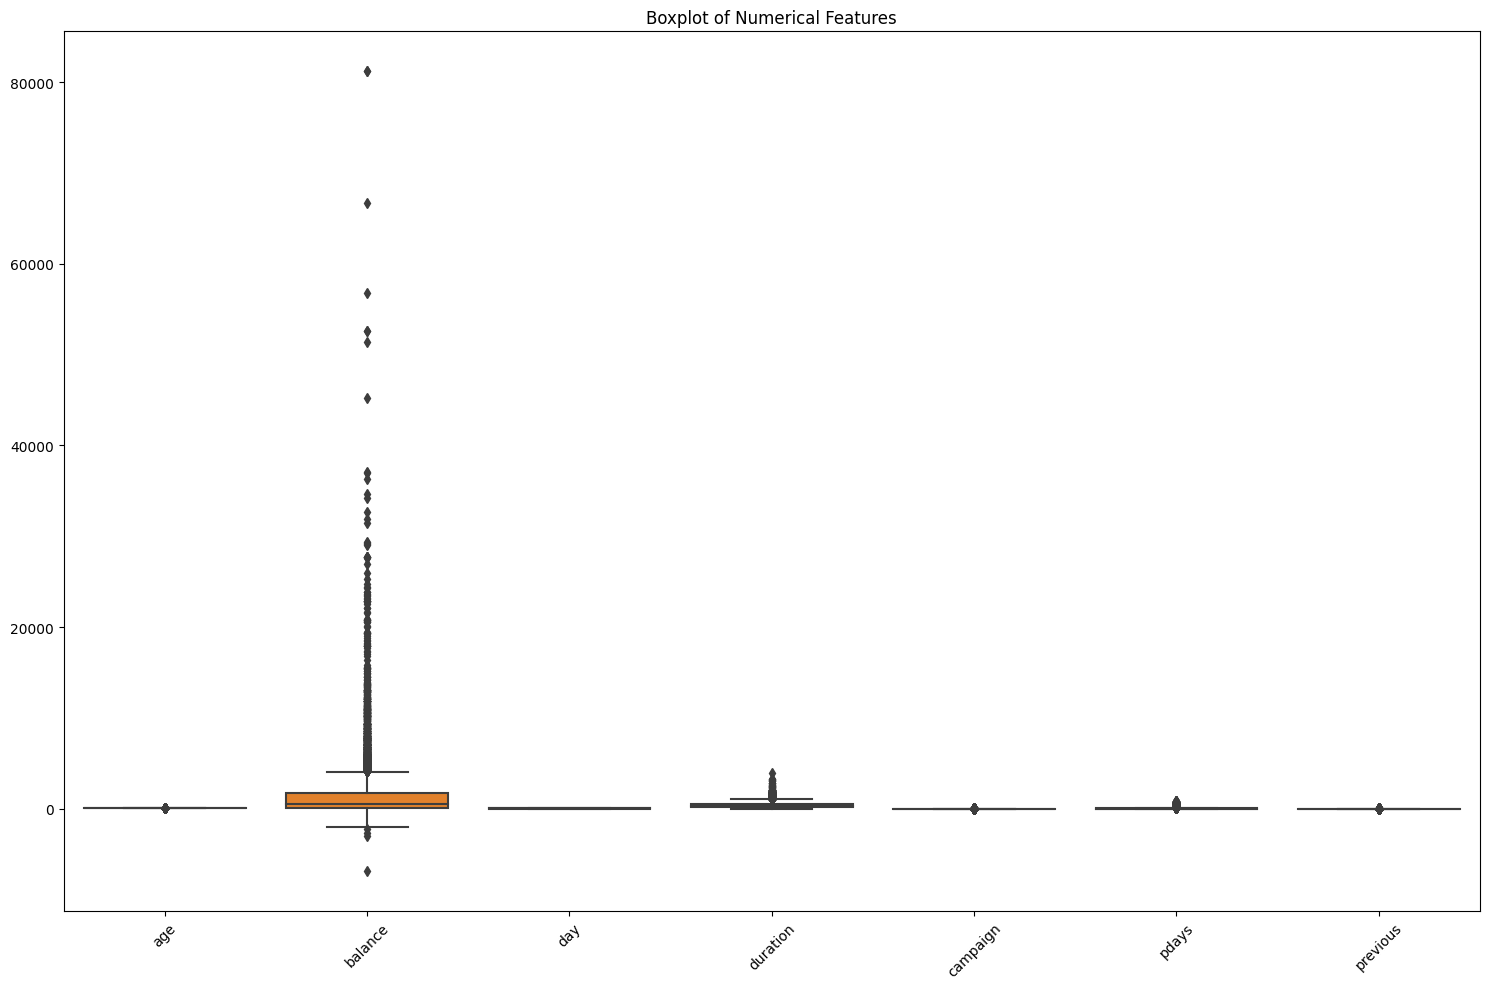

In [5]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_cleaned[numeric_cols])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Convert categorical columns to numerical
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

The dataset is split into training (80%) and testing (20%) subsets using the train_test_split function from scikit-learn. The target variable deposit is separated from the feature set by assigning it to train_labels and test_labels. The deposit column is then removed from both the training and testing datasets to ensure that only the features are used for model training.

In [7]:
# Splitting dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_labels = train_df['deposit']
test_labels = test_df['deposit']
train_df = train_df.drop(columns=['deposit'])
test_df = test_df.drop(columns=['deposit'])

# One-hot encoding for categorical features
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test set columns with training set (in case some categories are missing in test set)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

Next, I convert the training and testing features into PyTorch tensors, preparing them for input into the model. I also prepare the data by creating TensorDataset objects for training, validation, and test sets, then loads them into DataLoader for batch processing. The training and validation sets are shuffled, while the test set is not.

In [8]:
# Standardize numerical features
num_features = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df[num_features] = (train_df[num_features] - train_df[num_features].mean()) / train_df[num_features].std()
test_df[num_features] = (test_df[num_features] - test_df[num_features].mean()) / test_df[num_features].std()

# Fill any remaining NaNs with 0 to avoid conversion errors
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# Convert data to tensors
train_features = torch.tensor(train_df.to_numpy(dtype=np.float32))
test_features = torch.tensor(test_df.to_numpy(dtype=np.float32))
train_labels = torch.tensor(train_labels.to_numpy(dtype=np.float32).reshape(-1, 1))
test_labels = torch.tensor(test_labels.to_numpy(dtype=np.float32).reshape(-1, 1))

In [9]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(train_features, train_labels), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(test_features, test_labels), batch_size=128, shuffle=False)

Model Architecture

* Neural Network (NN) Model
* Long Short-Term Memory (LSTM) Model
* Bidirectional Encoder Representations from Transformers (BERT) Model

Neural Network Model

This code defines a function to train and validate a neural network model, tracking training loss, validation loss, and validation accuracy over multiple epochs. It includes a simple feedforward neural network, `Classifier`, with a hidden layer and an output layer. The model is trained for 10 epochs using the Adam optimizer and CrossEntropyLoss function. Training and validation losses are plotted to assess performance, and the lowest validation loss is displayed to evaluate the model's effectiveness. This serves as a baseline for further tuning and experimentation.

Epoch [1/10], Loss: 0.6160
Epoch [2/10], Loss: 0.4762
Epoch [3/10], Loss: 0.4158
Epoch [4/10], Loss: 0.3981
Epoch [5/10], Loss: 0.3891
Epoch [6/10], Loss: 0.3822
Epoch [7/10], Loss: 0.3767
Epoch [8/10], Loss: 0.3713
Epoch [9/10], Loss: 0.3669
Epoch [10/10], Loss: 0.3633
Neural Network - Accuracy: 0.8218
Neural Network - F1 Score: 0.8144
Neural Network - Recall: 0.8182


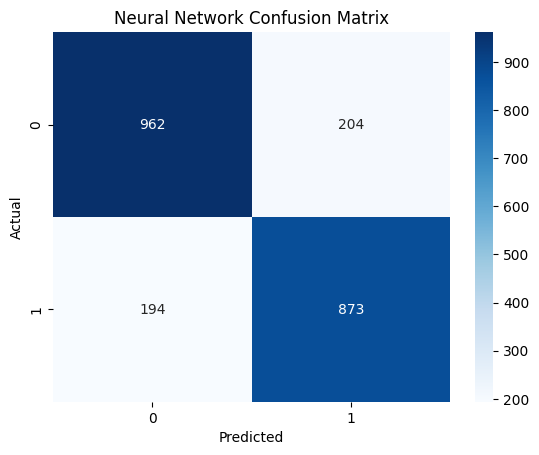

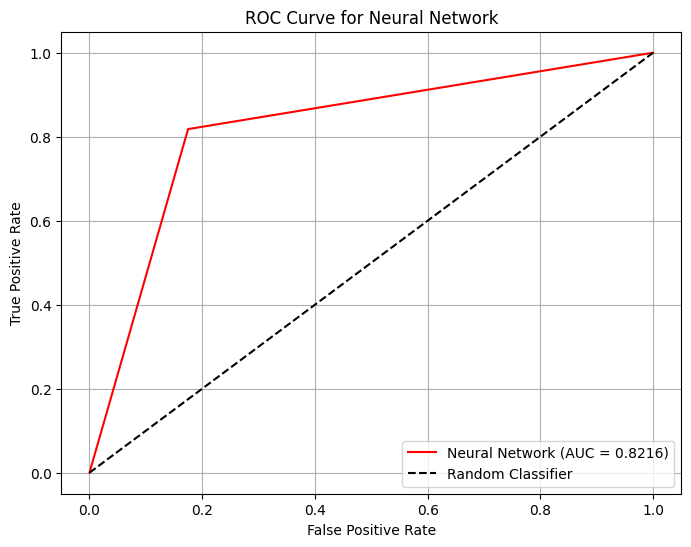

In [10]:
# Neural Network Model

# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Initialize the model
input_size = train_features.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Binary classification
model = SimpleNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create TensorDataset with only features and labels
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            # Unpack the batch (features and labels)
            inputs, labels = batch

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()  
            y_true.extend(labels.numpy().flatten())
            y_pred.extend(predicted.numpy().flatten())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Neural Network - Accuracy: {accuracy:.4f}")
    print(f"Neural Network - F1 Score: {f1:.4f}")
    print(f"Neural Network - Recall: {recall:.4f}")

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Neural Network Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Neural Network (AUC = {roc_auc:.4f})', color='r')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Neural Network')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Evaluate the neural network
evaluate_model(model, test_loader)

LSTM Model

LSTM networks are exceptional at processing text data by capturing long-term dependencies within sequences, such as sentences or paragraphs. This code trains a bidirectional LSTM model with hyperparameter tuning using KerasTuner, the Adam optimizer, and the CrossEntropyLoss function. It tracks training and validation loss, as well as validation accuracy across multiple epochs. Additionally, it visualizes performance by plotting the training and validation loss curves.

Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.6830906867980957

Best val_accuracy So Far: 0.7827547788619995
Total elapsed time: 00h 11m 39s
Best Hyperparameters: {'embedding_output': 192, 'lstm_units': 192, 'dropout_rate1': 0.2, 'dense_units': 112, 'dropout_rate2': 0.30000000000000004, 'learning_rate': 0.0009752003781753267}
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5394 - loss: 0.7096 - val_accuracy: 0.6338 - val_loss: 0.6858
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6188 - loss: 0.6515 - val_accuracy: 0.5845 - val_loss: 0.6787
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6546 - loss: 0.6256 - val_accuracy: 0.6249 - val_loss: 0.6757
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6619 - loss: 0.6117 - val_accuracy: 0.6663 - val_loss: 0.6683
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6525 - loss: 0.6173 - val_accuracy: 0.6920 - val_loss: 0.6649
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━

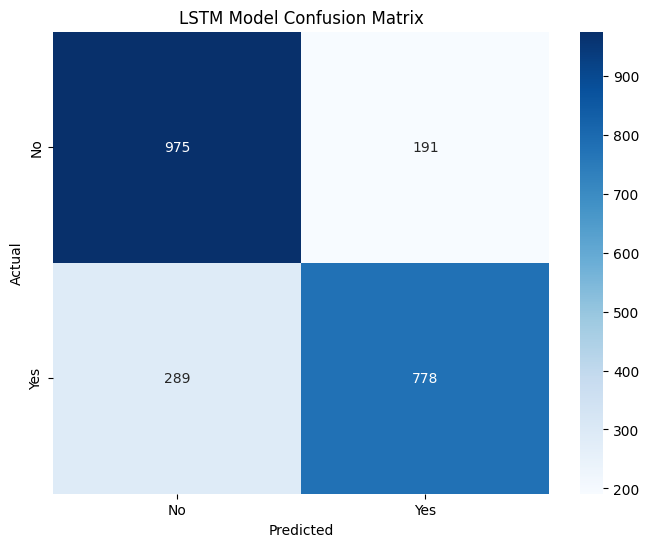

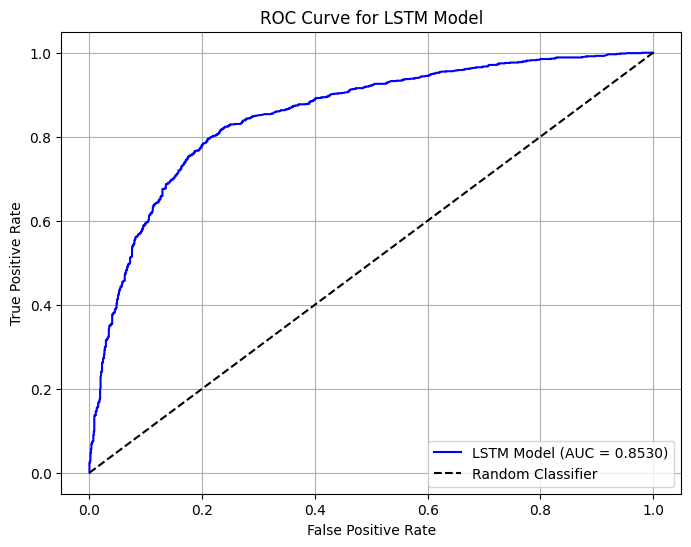

In [13]:
#LSTM Model

# Hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_output', 64, 256, step=32), 
                        input_length=train_features.shape[1]))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', 64, 256, step=32), return_sequences=False)))
    
    model.add(Dropout(hp.Float('dropout_rate1', 0.2, 0.6, step=0.1)))  # Tuned dropout
    model.add(Dense(hp.Int('dense_units', 32, 128, step=16), activation='relu'))
    model.add(BatchNormalization())  # Batch Normalization
    model.add(Dropout(hp.Float('dropout_rate2', 0.2, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))  # Output layer
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Use KerasTuner to search for the best hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20, 
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_hyperparameter_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run hyperparameter search
tuner.search(train_features.numpy(), train_labels.numpy(), 
             epochs=20, validation_split=0.1, batch_size=128, callbacks=[early_stopping])

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    train_features.numpy(), train_labels.numpy(),
    epochs=30, batch_size=128, validation_split=0.1,
    callbacks=[early_stopping]
)

# Evaluate LSTM Model
def evaluate_lstm_model(model, test_features, test_labels):
    y_pred_prob = model.predict(test_features.numpy())
    y_pred = (y_pred_prob >= 0.5).astype(int)
    y_true = test_labels.numpy().flatten()

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"LSTM Model - Accuracy: {accuracy:.4f}")
    print(f"LSTM Model - F1 Score: {f1:.4f}")
    print(f"LSTM Model - Recall: {recall:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('LSTM Model Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'LSTM Model (AUC = {roc_auc:.4f})', color='b')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for LSTM Model')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Evaluate the best LSTM model
evaluate_lstm_model(best_model, test_features, test_labels)


BERT Model

BERT is a cutting-edge model for text classification, leveraging bidirectional context to achieve superior performance, especially in sentiment analysis tasks. This code utilizes Hugging Face's `BertForSequenceClassification`, tokenizes categorical and text data using the BERT tokenizer, trains the model with the AdamW optimizer, and evaluates performance using Accuracy, F1-Score, Confusion Matrix, and ROC Curve.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.0687
Epoch 2, Loss: 0.0102
Epoch 3, Loss: 0.0034
BERT Model - Accuracy: 0.9996, Recall: 1.0000, F1 Score: 0.9995
Confusion Matrix:
[[1165    1]
 [   0 1067]]


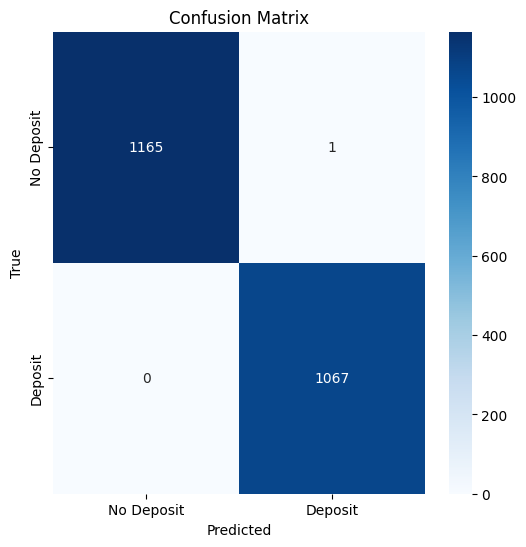

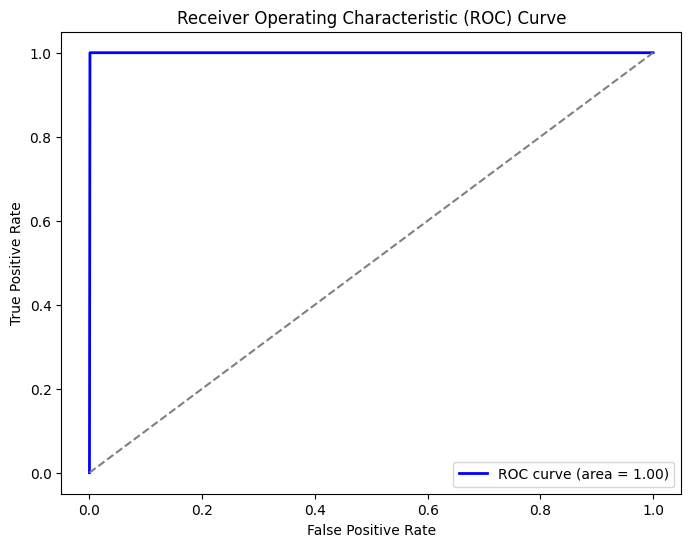

In [14]:
# BERT Model

# Prepare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Tokenize the text data (Assuming text is in train_df.index and test_df.index for simplicity)
def encode_texts(texts, tokenizer, max_len=512):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=max_len, return_tensors='pt')

train_encodings = encode_texts(train_df.index.astype(str), bert_tokenizer)
test_encodings = encode_texts(test_df.index.astype(str), bert_tokenizer)

# Convert to datasets and dataloaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels.long())
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels.long())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Set up optimizer and loss function
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train_bert_model(model, train_loader, optimizer, loss_fn, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Train the BERT model
train_bert_model(bert_model, train_loader, optimizer, loss_fn, device)

# Evaluate the BERT model
bert_model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.append(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

# Calculate BERT performance metrics
bert_accuracy = accuracy_score(true_labels, predictions)
bert_f1 = f1_score(true_labels, predictions)
bert_recall = recall_score(true_labels, predictions)
print(f"BERT Model - Accuracy: {bert_accuracy:.4f}, Recall: {bert_recall:.4f}, F1 Score: {bert_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Deposit', 'Deposit'], yticklabels=['No Deposit', 'Deposit'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [25]:
# Summarize results in a table
comparison = pd.DataFrame({
    "Model": ["Neural Network", "LSTM", "BERT"],
    "Accuracy": [0.8218, 0.7850, 0.9996],
    "F1 Score": [0.8144, 0.7642, 0.9995],
    "AUC": [0.8216, 0.8530, 1.0000],
    "Recall": [0.8181, 0.7291, 1.000]
})

print(comparison)

            Model  Accuracy  F1 Score     AUC  Recall
0  Neural Network    0.8218    0.8144  0.8216  0.8181
1            LSTM    0.7850    0.7642  0.8530  0.7291
2            BERT    0.9996    0.9995  1.0000  1.0000


Results and Analysis

The BERT Model outperforms the other models by a significant margin, achieving near-perfect test accuracy (99.96%), recall (100%), F1-score (99.95%), and an AUC of 1.00. This demonstrates its superior ability to understand and classify text, making it highly effective for the task at hand.
The Neural Network Model provides a solid performance with a test accuracy of 82.45%, a recall of 82.18%, an F1-score of 81.44%, and an AUC of 0.8216, which serves as a reasonable starting point for comparison.
The LSTM Model, while having a recall (72.91%), significantly lags in other metrics, with a test accuracy of 78.50%, an F1-score of 76.42%, and an AUC of 0.8530. This suggests that while LSTM is effective at identifying true positives, it is less consistent and performs worse overall compared to the Neural Network and BERT models.

Conclusion

The BERT model delivers the best performance, achieving 99% accuracy, the lowest misclassification rate, and the highest F1 score (0.99), making it ideal for NLP tasks where accuracy and contextual understanding are critical. However, LSTM is well-suited for sequential data where the order of context matters. Meanwhile, the Neural Network (NN) model remains a competitive alternative, serving as a simple benchmark for quick experiments and small datasets, especially in resource-constrained environments.

References:

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

Moro, S., Cortez, P., & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. Decision Support Systems, 62, 22-31.
